# Quality Control of Whole Genome Sequencing

## Helper function

In [1]:
import os
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

# Ignore FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress the UserWarning related to 'palette' and other warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Function to flatten the JSON and keep only leaf nodes
def flatten_json(json_obj, prefix=''):
    flat_data = {}
    for key, value in json_obj.items():
        # Check if value is a dictionary (i.e., nested) or if it's a leaf node
        if isinstance(value, dict):
            flat_data.update(flatten_json(value))  # Recursively flatten nested dictionaries
        else:
            flat_data[key] = value  # Leaf node, add to flat_data
    return flat_data

# Function to load the JSON in a DataFrame
def load_metrics(directory):
    
    # Initialize an empty list to store the parsed JSON data
    data_list = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".metrics.json"):  # Only process .json files
            filepath = os.path.join(directory, filename)
            # Open and load each JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
                # Flatten the JSON and keep only leaf nodes
                flat_data = flatten_json(data)
                # Append to the data list
                data_list.append(flat_data)
    
    # Create a DataFrame from the list of flat data
    df = pd.DataFrame(data_list)
    # Append sample info
    return append_info(df)

## Append sample info
def append_info(df):
    df_info = pd.read_csv('../n.100-1kg-sample-info-igsr.csv')
    df_merged = df.merge(df_info, left_on='id', right_on='Sample_name')
    return df_merged

def scatter(df_A, df_B, col):
    # Merge A and B
    df_ = pd.merge(df_A.loc[:,['id', col]], df_B.loc[:,['id', col]], on='id', how='outer')
    
    # Create a scatter plot
    sns.scatterplot(data=df_, x=f'{col}_x', y=f'{col}_y')

    # Calculate correlation coefficient
    corr = df_[f'{col}_x'].corr(df_[f'{col}_y'])
    plt.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=plt.gca().transAxes)

    # Add diagonale line
    gmin = min(df_[f'{col}_x'].min(), df_[f'{col}_y'].min())
    gmax = max(df_[f'{col}_x'].max(), df_[f'{col}_y'].max())
    plt.plot([gmin, gmax], [gmin, gmax], color='red', linestyle='--')
    
    # Set plot title and labels
    plt.title(f'{col}')
    plt.xlabel(f'{A_label}')
    plt.ylabel(f'{B_label}')

    if col in formatter:
        plt.gca().xaxis.set_major_formatter(formatter[col])
        plt.gca().yaxis.set_major_formatter(formatter[col])

    if col in ylims:
        plt.xlim(ylims[col][0], ylims[col][1])
        plt.ylim(ylims[col][0], ylims[col][1])
    
    # Show the plot
    plt.show()

In [2]:
formatter = {
    'cross_contamination_rate': tkr.PercentFormatter(xmax=1, decimals=2),
    # 'yield_bp_q30': tkr.EngFormatter(),
    # 'count_deletions': tkr.EngFormatter(),
    # 'count_insertions': tkr.EngFormatter(),
    # 'count_snvs': tkr.EngFormatter(),
    
}
# Specify metrics ranges
ylims = {
    # 'cross_contamination_rate': [0, 0.1e-3]
}

## Compare NPM v0.13.5 vs ARGO ALN v1.1.0
### Alignment metrics

In [3]:
## Load metrics group A
A_label='NPM v0.13.5'
A_dir='../results-npm-sample-qc-v0.13.5'
df_A = load_metrics(A_dir)
df_A

,id,cross_contamination_rate,insert_size_std_deviation,mad_autosome_coverage,mean_autosome_coverage,mean_insert_size,pct_autosomes_15x,pct_reads_mapped,pct_reads_properly_paired,yield_bp_q30,...,ratio_transitions_transversions_snv,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,HG00100,0.0000,99.4,4,29.94,430.1,95.90,99.78,98.19,102984371235,...,1.96,HG00100,female,SAME125154,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,NA18530,0.0000,101.5,5,32.22,444.7,96.04,99.71,97.78,110139268123,...,1.96,NA18530,male,SAME124484,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA18525,0.0000,100.3,5,31.40,444.1,95.93,99.73,97.95,107195224610,...,1.96,NA18525,female,SAME124672,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,NA19025,0.0000,100.9,5,32.26,436.9,95.98,99.79,98.05,111697530269,...,1.97,NA19025,male,SAME124852,LWK,Luhya,AFR,African Ancestry,LWK,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,NA19701,0.0000,100.4,4,31.41,435.5,95.90,99.77,97.91,111450499179,...,1.97,NA19701,female,SAME124232,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HG02601,0.0000,100.4,4,29.54,441.5,95.80,99.75,97.95,106639572556,...,1.96,HG02601,female,SAME1840293,PJL,Punjabi,SAS,South Asian Ancestry,PJL,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,HG03718,0.0007,93.6,4,28.83,415.0,95.72,99.69,97.59,98901640832,...,1.96,HG03718,male,SAME1839834,ITU,Telugu,SAS,South Asian Ancestry,ITU,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,HG01880,0.0000,100.4,4,28.63,437.4,95.66,99.76,98.09,101207705433,...,1.97,HG01880,female,SAME1839109,ACB,African Caribbean,AFR,African Ancestry,ACB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,NA19650,0.0000,101.4,5,33.39,450.2,96.07,99.75,98.22,108960909689,...,1.96,NA19650,male,SAME124976,MXL,Mexican Ancestry,AMR,American Ancestry,MXL,"1000 Genomes 30x on GRCh38,Human Genome Struct..."


In [4]:
## Load metrics group B
B_label='ARGO ALN v1.1.0'
B_dir='../results-argo-dnaalnqc-v1.1.0'
df_B = load_metrics(B_dir)
df_B

,id,yield_bp_q30,mean_autosome_coverage,pct_autosomes_15x,mad_autosome_coverage,pct_reads_mapped,pct_reads_properly_paired,mean_insert_size,insert_size_std_deviation,cross_contamination_rate,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,HG00100,1.029844e+11,29.94,95.90,4.0,99.78,98.19,430.1,99.4,0.0000,HG00100,female,SAME125154,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,NA18530,1.101393e+11,32.22,96.04,5.0,99.71,97.78,444.7,101.5,0.0000,NA18530,male,SAME124484,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA18525,1.071952e+11,31.40,95.93,5.0,99.73,97.95,444.1,100.3,0.0000,NA18525,female,SAME124672,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,NA19025,1.116975e+11,32.26,95.98,5.0,99.79,98.05,436.9,100.9,0.0000,NA19025,male,SAME124852,LWK,Luhya,AFR,African Ancestry,LWK,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,NA19701,1.114505e+11,31.41,95.90,4.0,99.77,97.91,435.5,100.4,0.0000,NA19701,female,SAME124232,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HG02601,1.066396e+11,29.54,95.80,4.0,99.75,97.95,441.5,100.4,0.0002,HG02601,female,SAME1840293,PJL,Punjabi,SAS,South Asian Ancestry,PJL,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,HG03718,9.890164e+10,28.83,95.72,4.0,99.69,97.59,415.0,93.6,0.0010,HG03718,male,SAME1839834,ITU,Telugu,SAS,South Asian Ancestry,ITU,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,HG01880,1.012077e+11,28.63,95.66,4.0,99.76,98.09,437.4,100.4,0.0000,HG01880,female,SAME1839109,ACB,African Caribbean,AFR,African Ancestry,ACB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,NA19650,1.089609e+11,33.39,96.07,5.0,99.75,98.22,450.2,101.4,0.0000,NA19650,male,SAME124976,MXL,Mexican Ancestry,AMR,American Ancestry,MXL,"1000 Genomes 30x on GRCh38,Human Genome Struct..."


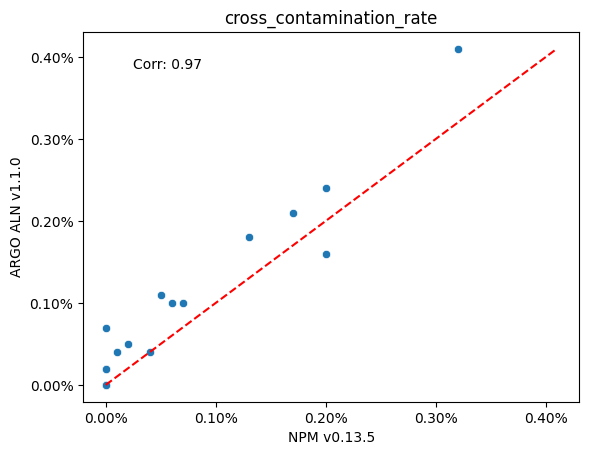

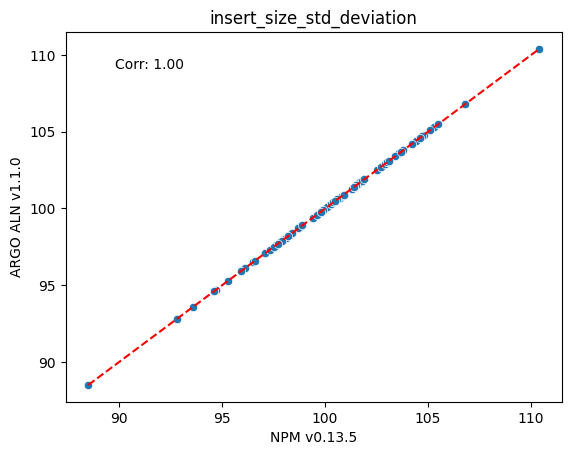

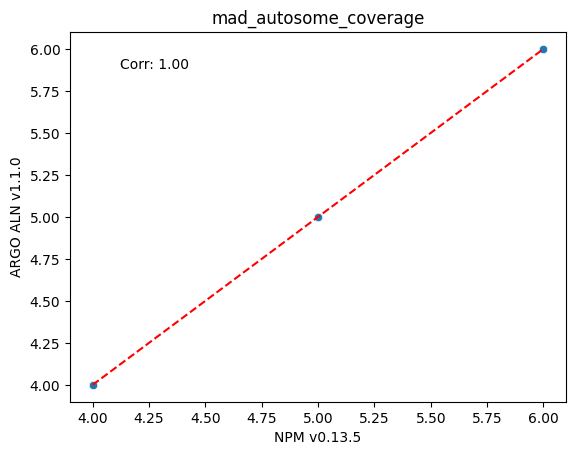

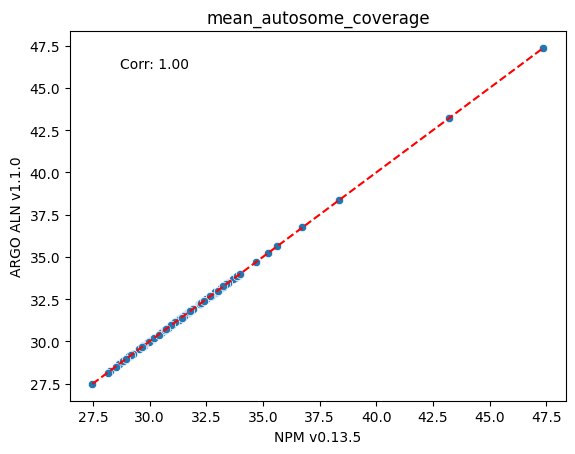

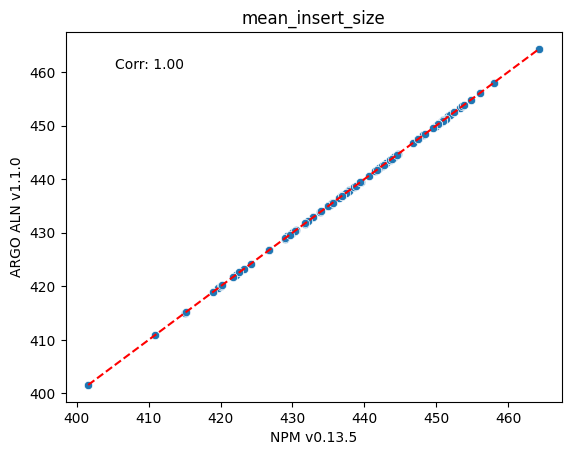

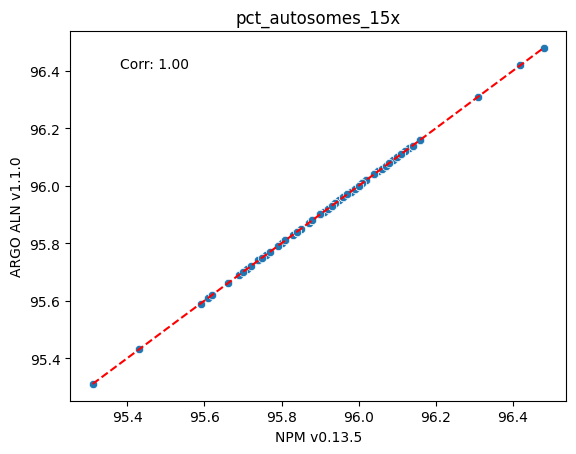

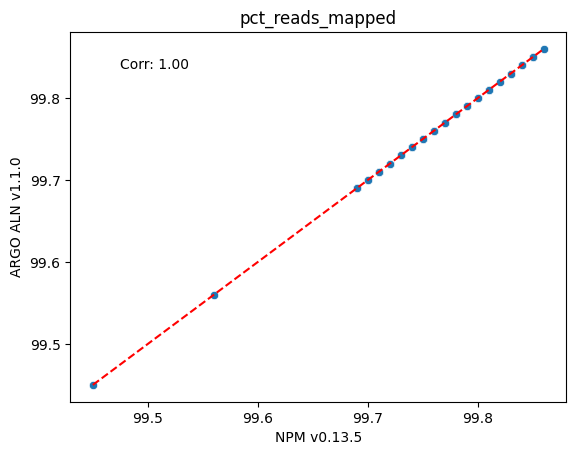

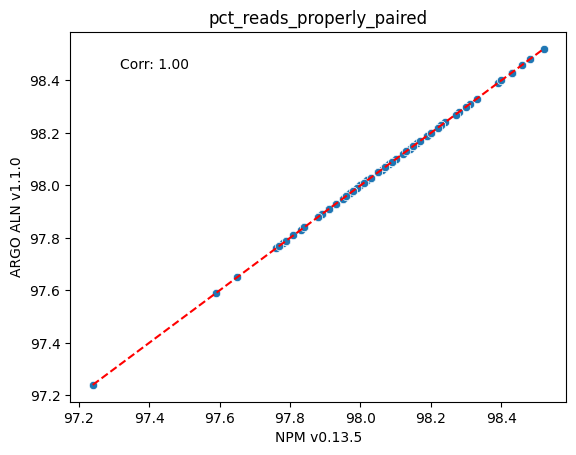

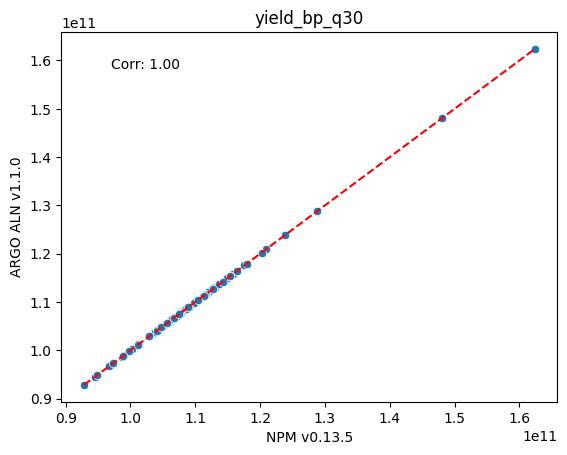

In [5]:
# Plot correlation for alignment metrics
for col in df_A.columns[1:10]:
    scatter(df_A, df_B, col)

## Compare NPM v0.13.5 vs ARGO VCF v1.0.0
### VCF metrics

In [6]:
## Load metrics group A
A_label='NPM v0.13.5'
A_dir='../results-npm-sample-qc-v0.13.5'
df_A = load_metrics(A_dir)
df_A

,id,cross_contamination_rate,insert_size_std_deviation,mad_autosome_coverage,mean_autosome_coverage,mean_insert_size,pct_autosomes_15x,pct_reads_mapped,pct_reads_properly_paired,yield_bp_q30,...,ratio_transitions_transversions_snv,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,HG00100,0.0000,99.4,4,29.94,430.1,95.90,99.78,98.19,102984371235,...,1.96,HG00100,female,SAME125154,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,NA18530,0.0000,101.5,5,32.22,444.7,96.04,99.71,97.78,110139268123,...,1.96,NA18530,male,SAME124484,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA18525,0.0000,100.3,5,31.40,444.1,95.93,99.73,97.95,107195224610,...,1.96,NA18525,female,SAME124672,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,NA19025,0.0000,100.9,5,32.26,436.9,95.98,99.79,98.05,111697530269,...,1.97,NA19025,male,SAME124852,LWK,Luhya,AFR,African Ancestry,LWK,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,NA19701,0.0000,100.4,4,31.41,435.5,95.90,99.77,97.91,111450499179,...,1.97,NA19701,female,SAME124232,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HG02601,0.0000,100.4,4,29.54,441.5,95.80,99.75,97.95,106639572556,...,1.96,HG02601,female,SAME1840293,PJL,Punjabi,SAS,South Asian Ancestry,PJL,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,HG03718,0.0007,93.6,4,28.83,415.0,95.72,99.69,97.59,98901640832,...,1.96,HG03718,male,SAME1839834,ITU,Telugu,SAS,South Asian Ancestry,ITU,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,HG01880,0.0000,100.4,4,28.63,437.4,95.66,99.76,98.09,101207705433,...,1.97,HG01880,female,SAME1839109,ACB,African Caribbean,AFR,African Ancestry,ACB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,NA19650,0.0000,101.4,5,33.39,450.2,96.07,99.75,98.22,108960909689,...,1.96,NA19650,male,SAME124976,MXL,Mexican Ancestry,AMR,American Ancestry,MXL,"1000 Genomes 30x on GRCh38,Human Genome Struct..."


In [7]:
## Load metrics group B
B_label='ARGO VCF v1.0.0'
B_dir='../results-argo-vcfqc-v1.0.0'
df_B = load_metrics(B_dir)
df_B

,id,ratio_transitions_transversions_snv,count_deletions,ratio_heterozygous_homzygous_indel,ratio_heterozygous_homzygous_snv,count_insertions,ratio_insertion_deletion,count_snvs,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,HG00404,1.95,484952,1.69,1.37,482260,0.99,3922657,HG00404,female,SAME123158,CHS,Southern Han Chinese,EAS,East Asian Ancestry,CHS,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,HG00177,1.96,479465,1.92,1.55,476583,0.99,3866918,HG00177,female,SAME124957,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA18484,1.97,584394,2.62,1.98,570003,0.98,4719341,NA18484,female,SAME124101,YRI,Yoruba,AFR,African Ancestry,YRI,"1000 Genomes 30x on GRCh38,1000 Genomes phase ..."
3,HG01583,1.96,497845,2.08,1.65,492058,0.99,4002439,HG01583,male,SAME1839895,PJL,Punjabi,SAS,South Asian Ancestry,PJL,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,HG00552,1.97,498801,2.17,1.72,494070,0.99,4007326,HG00552,male,SAME124253,PUR,Puerto Rican,AMR,American Ancestry,PUR,"1000 Genomes 30x on GRCh38,1000 Genomes phase ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HG03720,1.96,495010,1.98,1.59,491032,0.99,3998709,HG03720,male,SAME1839562,ITU,Telugu,SAS,South Asian Ancestry,ITU,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,HG02922,1.97,584779,2.64,2.01,571327,0.98,4743251,HG02922,female,SAME1839441,ESN,Esan,AFR,African Ancestry,ESN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,HG01507,1.96,485814,2.02,1.61,483079,0.99,3917856,HG01507,female,SAME124948,IBS,Iberian,EUR,European Ancestry,IBS,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,HG01840,1.96,486046,1.73,1.40,484304,1.00,3926923,HG01840,male,SAME123552,KHV,Kinh Vietnamese,EAS,East Asian Ancestry,KHV,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


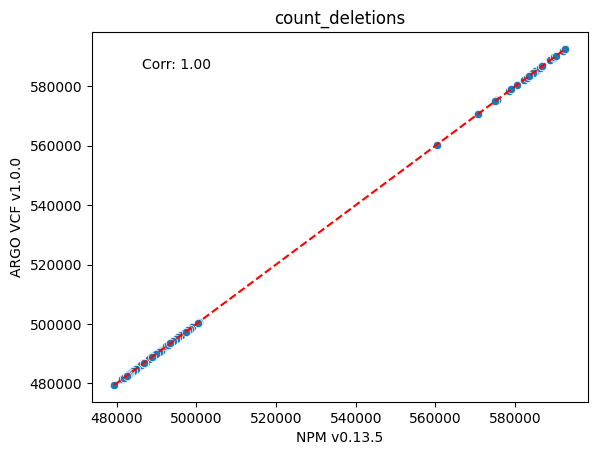

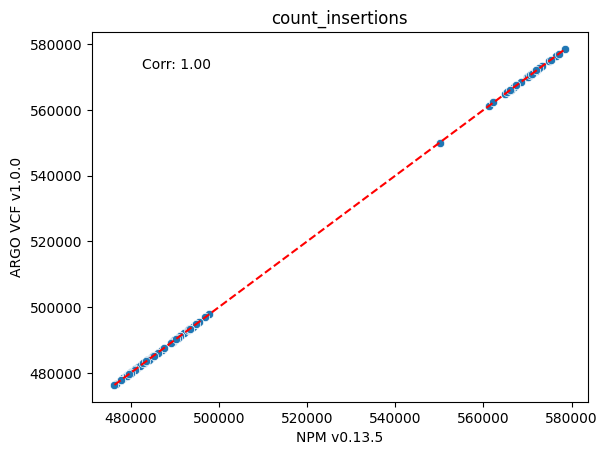

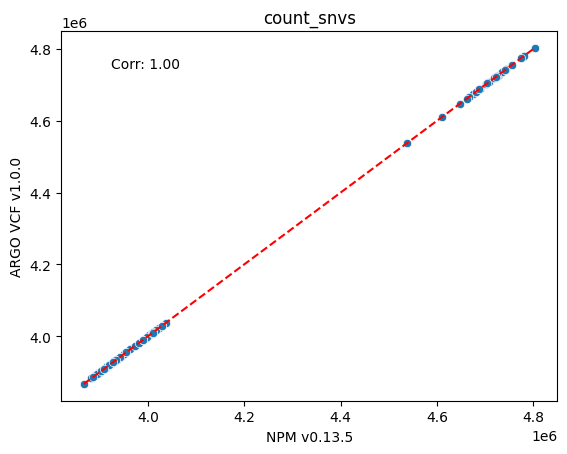

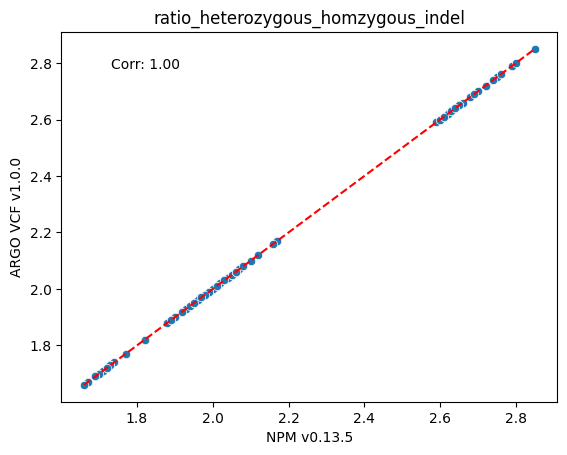

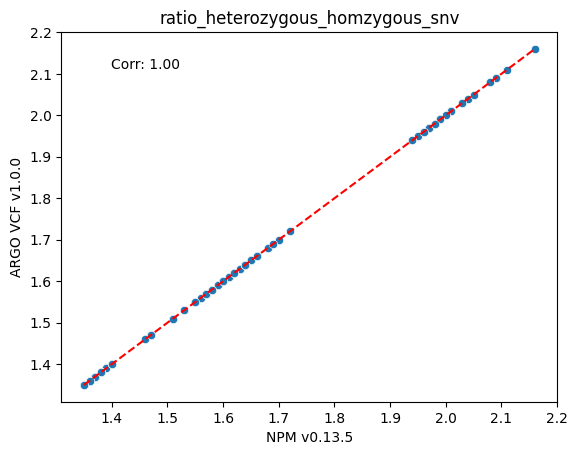

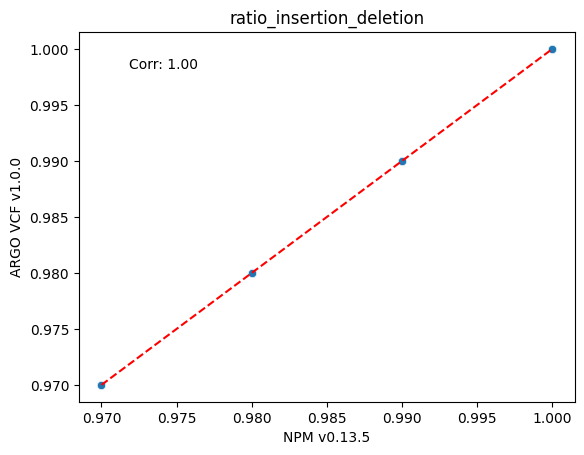

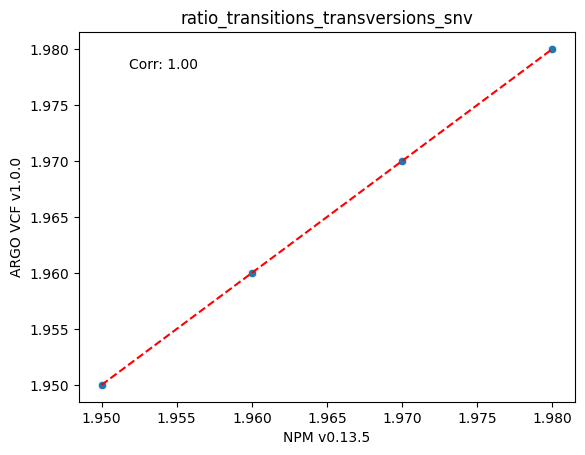

In [8]:
# Plot correlation for VCF metrics
for col in df_A.columns[10:17]:
    scatter(df_A, df_B, col)